In [1]:
import os
import random
import torch
import numpy as np
from PIL import Image
from pycocotools import mask as coco_mask
from groundingdino.util.inference import load_model, load_image, predict, annotate
from groundingdino.util import box_ops
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from segment_anything.utils.amg import (mask_to_rle_pytorch, 
                                        rle_to_mask,
                                        area_from_rle,
                                        remove_small_regions,
                                       )


In [2]:
SAM_CHECKPOINT = "/scratch/gpfs/eh0560/segment-anything/sam_models/sam_vit_h_4b8939.pth"
MODEL_TYPE = "vit_h"

DINO_MODEL_PATH = "/scratch/gpfs/eh0560/GroundingDINO/models/groundingdino_swinb_cogcoor.pth"
DINO_CONFIG_PATH = "/scratch/gpfs/eh0560/GroundingDINO/groundingdino/config/GroundingDINO_SwinB_cfg.py"

DEVICE = "cuda"

In [3]:
def load_sam_model(checkpoint, model_type, device):
    sam = sam_model_registry[model_type](checkpoint=checkpoint)
    return sam.to(device), SamPredictor(sam)

In [4]:
sam_model, sam_predictor = load_sam_model(SAM_CHECKPOINT, MODEL_TYPE, DEVICE)

In [5]:
dino_model = load_model(DINO_CONFIG_PATH, DINO_MODEL_PATH)

/home/eh0560/.conda/envs/torch_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
IMAGES_DIR = "/scratch/gpfs/RUSTOW/deskewing_datasets/images/cudl_images"

In [ ]:
def get_images(directory):
    jpg_paths = []

    for dirpath, dirnames, filenames in os.walk(directory):
        for filename in filenames:
            if filename.lower().endswith('.jpg'):
                full_path = os.path.join(dirpath, filename)
                jpg_paths.append(full_path)

    return jpg_paths#%%
cudl_images = get_images(IMAGES_DIR)

In [ ]:
image_path = cudl_images[random.randint(0, len(cudl_images))]


In [ ]:
TEXT_PROMPT = "scanned document"
BOX_THRESHOLD = 0.45
TEXT_THRESHOLD = 0.25

In [ ]:
image_source, image = load_image(image_path)
boxes, logits, phrases = predict(dino_model, image, TEXT_PROMPT, BOX_THRESHOLD, TEXT_THRESHOLD)
annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)[...,::-1]

In [ ]:
sam_predictor.set_image(image_source)

H, W, _ = image_source.shape
boxes_xyxy = box_ops.box_cxcywh_to_xyxy(boxes) * torch.Tensor([W, H, W, H])
transformed_boxes = sam_predictor.transform.apply_boxes_torch(boxes_xyxy, image_source.shape[:2]).to(DEVICE)

masks, iou_preds, logits = sam_predictor.predict_torch(
    point_coords=None,
    point_labels=None,
    boxes=transformed_boxes,
    multimask_output=False
)

flattened_mask = masks.sum(dim=1)
masks = (flattened_mask == True).cpu().numpy()
# get first mask since batch size is 1
mask = masks[0]

mask, _ = remove_small_regions(mask, 100 * 100, "holes")
mask, _ = remove_small_regions(mask, 100 * 100, "islands")

In [ ]:
# rle = coco_mask.encode(np.asfortranarray(mask))
# mask = coco_mask.decode(rle)

/home/eh0560/.conda/envs/torch_env/lib/python3.9/site-packages/transformers/modeling_utils.py:884: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/home/eh0560/.conda/envs/torch_env/lib/python3.9/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


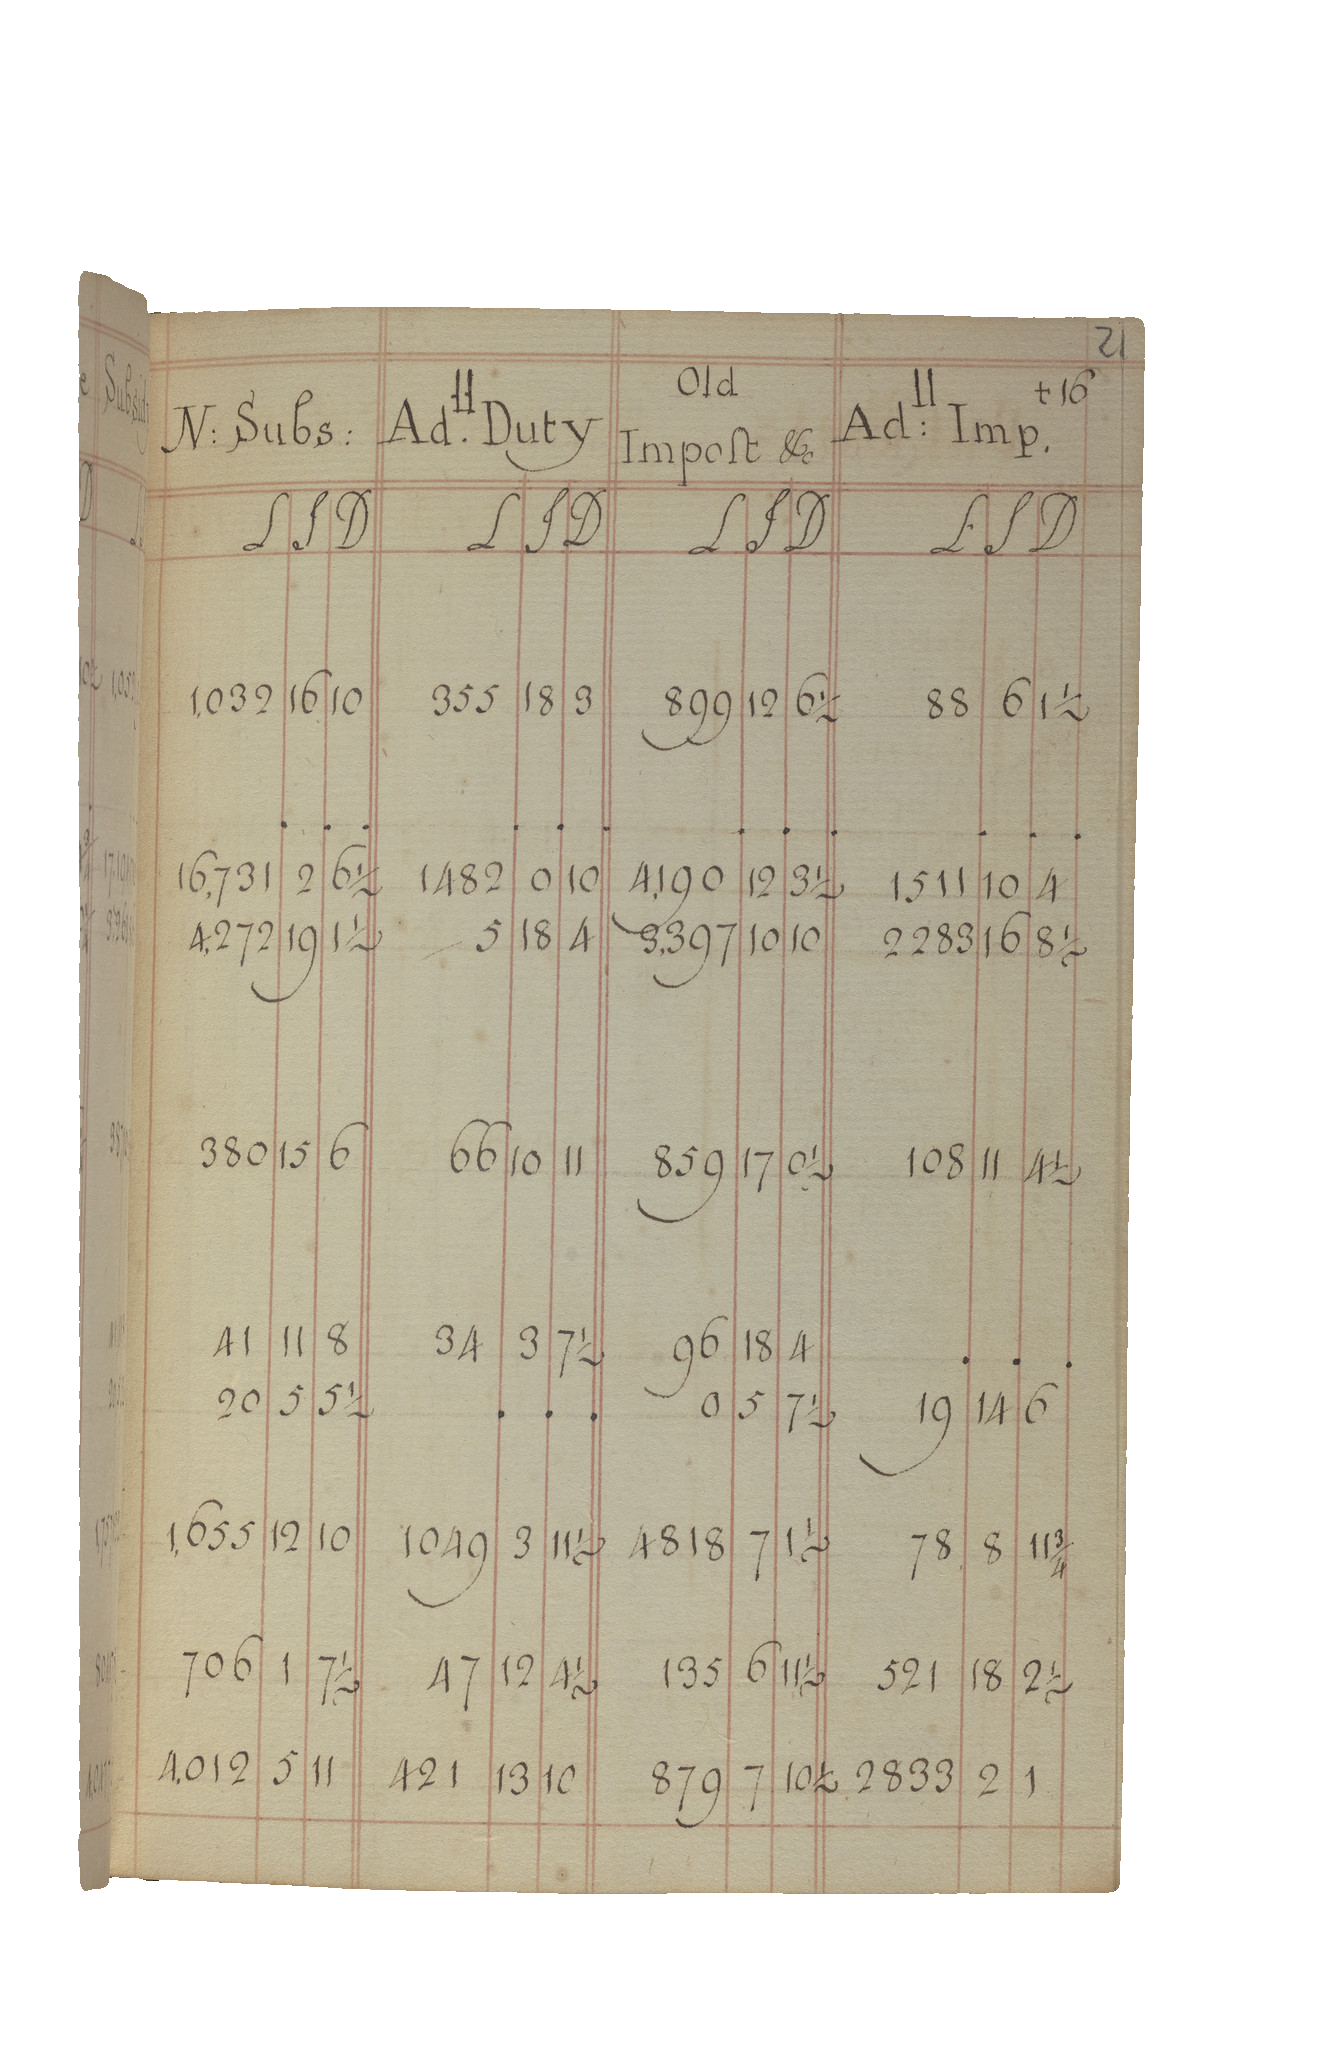

In [7]:

#%%
#%%

#%%


#%%

#%%
def visualize_mask(mask, image, random_color=True):
    color = np.concatenate([np.random.random(3), np.array([0.8])], axis=0) if random_color else np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    
    annotated_frame_pil = Image.fromarray(image).convert("RGBA")
    mask_image_pil = Image.fromarray((mask_image * 255).astype(np.uint8)).convert("RGBA")
    
    return np.array(Image.alpha_composite(annotated_frame_pil, mask_image_pil))
#%%
def remove_background(image, mask):
    mask = (mask > 0).astype(np.uint8)

    if mask.ndim == 2:
        mask = np.expand_dims(mask, axis=-1)
    
    alpha_channel = mask * 255 
    rgba_image = np.concatenate([image, alpha_channel], axis=-1)
    
    return rgba_image

#%%
annotated_frame_with_mask = visualize_mask(mask, annotated_frame)
image_without_background = remove_background(image_source, mask)
#%%
Image.fromarray(image_without_background)
# Image.fromarray(annotated_frame_with_mask)
#%%
